# Hard-clustering and Variations of k-means Algorithm

K-means algorithm has two possible formalisations:

* formalisation through distances
* formalisation through probabilistic modelling

In this notebook we explore the second formalisation as it allows us to define different algorithms that are suitable for vast array of possible circumstances.

In [19]:
import numpy as np
import pandas as pd
import numpy.random as rnd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hclust 
import sklearn

from pandas import Series
from pandas import DataFrame
from typing import List,Tuple

from pandas import Categorical
from pandas.api.types import CategoricalDtype

from tqdm import tnrange#, tqdm_notebook
from plotnine import *

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import uniform 


from sklearn.cluster import AgglomerativeClustering

# Local imports
from common import *
from convenience import *

## I. Probabilistic modelling for hard clustering

The hard-clustering task can be captured through the following probabilistic model

* There are $k$ different data sources $\mathcal{D}_1,\ldots,\mathcal{D}_k$
* Each data source $\mathcal{D}_j$ is defined through a set of parameters $\boldsymbol{\Theta}_j$.
* Parameters of all data sources are denoted by $\boldsymbol{\Theta}=(\boldsymbol{\Theta}_1,\ldots, \boldsymbol{\Theta}_k)$.
* Each datapoint $\boldsymbol{x}_i$ has a label $z_i$ that determines from which data source $\boldsymbol{x}_i$ is taken.
* Each sample $\boldsymbol{x}_i$ is independently sampled form all other datapoints. 

Our goal is to find the maximum-likelihood estimate

\begin{align*}
(\boldsymbol{z}_*, \boldsymbol{\Theta}_*)=\mathrm{argmax}_{\boldsymbol{z}, \boldsymbol{\Theta}} \Pr[\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n|\boldsymbol{z},\boldsymbol{\Theta}]
\end{align*}

## II. Two-step maximisation strategy 

As direct maximisation is intractable inpractise we use the following maximisation strategy:

* Choose some parameter values $\boldsymbol{\Theta}$.
* Find a label assignment $\boldsymbol{z}_*$ that maximises $\Pr[\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n|\boldsymbol{z},\boldsymbol{\Theta}_*]$ for fixed $\boldsymbol{\Theta}_*$.
* Find paramaeters $\boldsymbol{\Theta}_*$ that maximises $\Pr[\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n|\boldsymbol{z}_*,\boldsymbol{\Theta}]$ for a fixed label assignment $\boldsymbol{z}_*$.
* Repeat these steps until albelling does not change.

As all observations are independent then 

\begin{align*}
 \Pr[\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n|\boldsymbol{z},\boldsymbol{\Theta}_*]=
 \prod_{i=1}^n \Pr[\boldsymbol{x}_i|z_i,\boldsymbol{\Theta}_{z_i}]
\end{align*}

and thus for $\boldsymbol{x}_i$ we must find a data source $j$ that gives the higest probability $\Pr[\boldsymbol{x}_i,|z_i=j,\boldsymbol{\Theta}_{j}]$ over all $j\in\{1,\ldots,k\}$.

If the labelling is fixed then we can group the product into independent factors

\begin{align*}
\Pr[\boldsymbol{x}_1,\ldots, \boldsymbol{x}_n|\boldsymbol{z}_*,\boldsymbol{\Theta}]=
\prod_{j=1}^k\prod_{i\in \mathcal{I}_j} \Pr[\boldsymbol{x}_i|z_i=j,\boldsymbol{\Theta}_{j}]
\end{align*}
where $\mathcal{I}_j=\{i: z_i=j\}$ is the set of all datapoints assigned to the source $j$.

The latter is equivalent of finding maximum likelihood parameter estimates for each group $\mathcal{I}_j$ separately and is usually tractable though it can be technically quite demanding. 


# Homework

## 3.1 Implementation of k-means algorithm (<font color='red'>2p</font>) 

Recall that the k-means algorithm is a two-step minimisation procedure for maximising the likelihood of data $\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n$ by tuning cluster centres $\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_k$ and labels $z_1,\ldots,z_n$. 

According to the underlying probabilistic model each data point $\boldsymbol{x}_i$ is generated by taking the corresponding cluster centre $\boldsymbol{\mu}_{z_i}$ and adding a white gaussian noise $\mathcal{N}(0,\sigma)$ for each coordinate. We showed in the lecture that the likelihood maximisation is equivalent to the following minimisation task:
\begin{align*}
F(\boldsymbol{\Theta},\boldsymbol{z})=\sum_{i=1}^n ||\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i}||^2\to\min
\end{align*}   
where $\boldsymbol{\Theta}=(\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_k)$ denotes all model parameters.    


* Implement the two-step minimisation procedure. First, implement the step that finds optimal values for $\boldsymbol{z}$ given fixed $\boldsymbol{\Theta}$. Second, implement the step that finds optimal $\boldsymbol{\Theta}$ values given fixed $\boldsymbol{z}$. Load the data [`challenge-1.csv`](./data/gmm-challenges/challenge-1.csv) from the directory `data/gmm-challenges` and initialise three cluster centres by choosing $\boldsymbol{\mu}_1,\boldsymbol{\mu}_2,\boldsymbol{\mu}_3$ randomly form the range $[-4,4]\times [-4,4]$. Repeat minimisation steps $100$ times and visualise the end result by colouring data points into three different colours and showing the final locations of the cluster centres. (<font color='red'>**1p**</font>) 
  
* Now that you know a good estimate for the labels and cluster centres, you can find the mixture probabilities $\lambda_j=\Pr[z=j]$ as fractions of corresponding cluster labels. You can also estimate the parameter $\sigma$ in the original model by computing standard deviations of $x$ and $y$ values of error components $\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i}$. They should be roughly equal. Now that you have fixed all model parameters, you can test the applicability of the model by generating the same amount of data. Write a corresponding function and generate the data and compare it visually with the original data. Do you believe that the model adequately describes the data? 

* Load the data [`challenge-2.csv`](./data/gmm-challenges/challenge-2.csv) and [`challenge-2.csv`](./data/gmm-challenges/challenge-2.csv) from  from the directory `data/gmm-challenges` and find cluster centres by repeating the k-means minimisation procedure. As before estimate mixture probabilities $\lambda_1,\lambda_2,\lambda_3$ and overall variance parameter $\sigma$. Simulate the data as before and compare with the originals. Does the model adequately describes the data? (<font color='red'>**1p**</font>)  



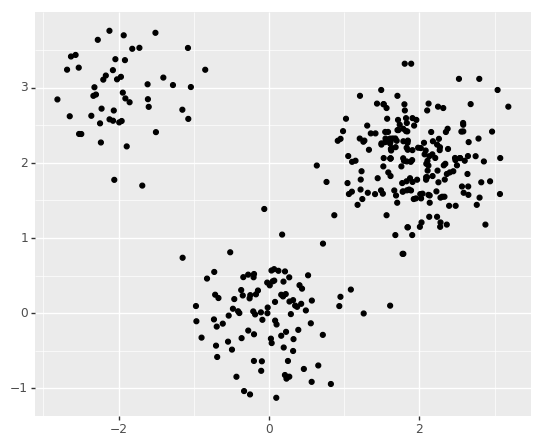

<ggplot: (-9223372029308528170)>

In [18]:
df = pd.read_csv('data/gmm-challenges/challenge-1.csv', usecols = [1,2])


p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'))
p = p + coord_fixed()
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Random initialisation

In [72]:
labelCat = CategoricalDtype(['d0', 'd1', 'd2'], ordered=True)

In [73]:
mu = (DataFrame(uniform().rvs(6).reshape([3,2]), columns = ['x', 'y'], index =['d0', 'd1', 'd2'])
      .reset_index()
      .rename(columns={'index':'cluster'})
      .assign(cluster = lambda df: df['cluster'].astype(labelCat))
     )
display(mu)

,cluster,x,y
0,d0,0.889295,0.331437
1,d1,0.958887,0.144898
2,d2,0.758943,0.300232


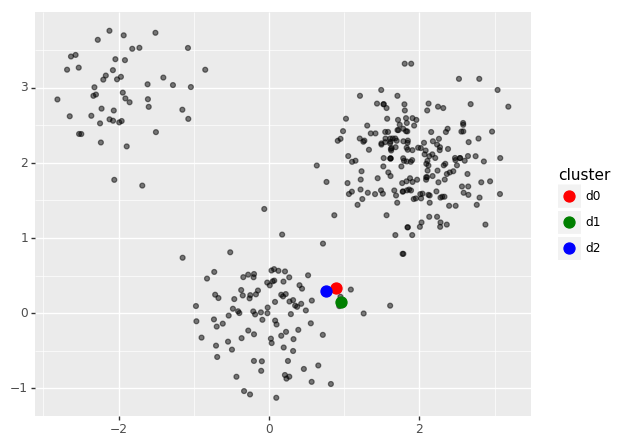

<ggplot: (-9223372029305130636)>

In [74]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha = 0.5)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'cluster'), data = mu, size=4, shape='o')
p = p + coord_fixed()
p = p + scale_color_manual(values=['red', 'green', 'blue'], breaks = ['d0', 'd1', 'd2'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Finding  distance minimising cluster labels

In [75]:
df = (df
      .assign(d0 = lambda df: (df['x']-mu.loc[0, 'x'])**2 + (df['y']-mu.loc[0, 'y'])**2)
      .assign(d1 = lambda df: (df['x']-mu.loc[1, 'x'])**2 + (df['y']-mu.loc[1, 'y'])**2)
      .assign(d2 = lambda df: (df['x']-mu.loc[2, 'x'])**2 + (df['y']-mu.loc[2, 'y'])**2)
     )
head(df)

,x,y,d0,d1,d2,z
0,1.842682,2.265546,4.649723,5.278241,5.036950,d2
1,1.313784,1.600775,1.791410,2.245530,1.999261,d2
2,0.320042,0.172759,0.349228,0.408899,0.208883,d1
3,0.009655,0.369287,0.775198,0.951392,0.566201,d2
4,1.520324,1.951488,3.022764,3.578981,3.306350,d2


In [76]:
df = df.assign(z = lambda df: df[['d0','d1','d2']].idxmin(axis = 1).astype(labelCat))
head(df)

,x,y,d0,d1,d2,z
0,1.842682,2.265546,4.649723,5.278241,5.036950,d0
1,1.313784,1.600775,1.791410,2.245530,1.999261,d0
2,0.320042,0.172759,0.349228,0.408899,0.208883,d2
3,0.009655,0.369287,0.775198,0.951392,0.566201,d2
4,1.520324,1.951488,3.022764,3.578981,3.306350,d0


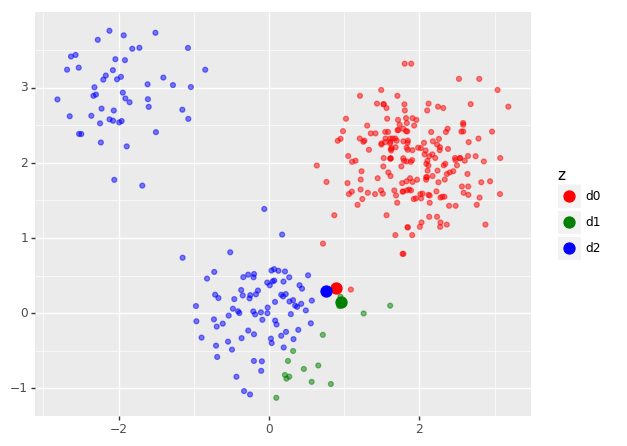

<ggplot: (-9223372029306612087)>

In [78]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'), alpha = 0.5)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'cluster'), data = mu, size=4, shape='o')
p = p + coord_fixed()
p = p + scale_color_manual(values=['red', 'green', 'blue'], breaks = ['d0', 'd1', 'd2'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

### Find distance minimising cluster centers 

In [87]:
mu.loc[0, ['x', 'y']] = df[df['z'] == 'd0'].aggregate({'x': np.mean, 'y':np.mean})
mu.loc[1, ['x', 'y']] = df[df['z'] == 'd1'].aggregate({'x': np.mean, 'y':np.mean})
mu.loc[2, ['x', 'y']] = df[df['z'] == 'd2'].aggregate({'x': np.mean, 'y':np.mean})


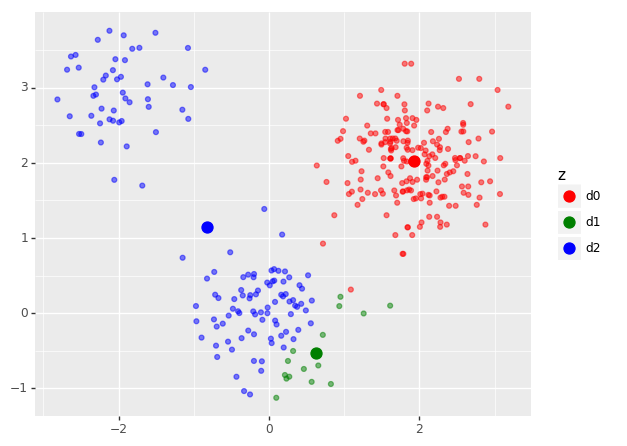

<ggplot: (7553580685)>

In [88]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'z'), alpha = 0.5)
p = p + geom_point(aes(x = 'x', y = 'y', color = 'cluster'), data = mu, size=4, shape='o')
p = p + coord_fixed()
p = p + scale_color_manual(values=['red', 'green', 'blue'], breaks = ['d0', 'd1', 'd2'])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
display(p)

## 3.2 Scaled implementation of k-means algorithm (<font color='red'>2p</font>) 

As the original k-means model seems to be inadequate for the dataset data [`challenge-2.csv`](./data/gmm-challenges/challenge-2.csv) from  from the directory `data/gmm-challenges`, we need to modify the probabilistic model. As the visual inspection clearly shows that the variance in different clusters is different, we should consider a modified data generation where each data point is generated by taking the corresponding cluster centre $\boldsymbol{\mu}_{z_i}$ and adding a random Gaussian noise $\NNN(0,\sigma_{z_i})$ for each coordinate. The corresponding likelihood can be expressed as
\begin{align*}
\Pr[\boldsymbol{x_i}|z_i=j,\boldsymbol{\Theta}]=\frac{1}{2\pi\sigma_j^2}\cdot\exp\Biggl(-\frac{1}{2\sigma_j^2}(\boldsymbol{x}_i-\boldsymbol{\mu}_j)^T(\boldsymbol{x}_i-\boldsymbol{\mu}_j)\Biggr)
\end{align*} 
and thus we must solve the following minimisation task
\begin{align*}
F(\boldsymbol{\Theta},\boldsymbol{z}) = 2\cdot \sum_{i=1}^n\log (\sigma_{z_i})+\sum_{i=1}^n \frac{||\boldsymbol{x}_i-\boldsymbol{\mu}_{z_i}||^2}{2\sigma_{z_j}^2}\to \min 
\end{align*}
where $\boldsymbol{\Theta}=(\vec{\mu}_1,\ldots,\vec{\mu}_k,\sigma_1,\ldots,\sigma_k)$ denotes all model parameters.    

* Implement the two-step minimisation procedure. First, implement the step that finds optimal values for $\boldsymbol{z}$ given fixed $\boldsymbol{\Theta}$. Second, implement the step that finds optimal $\boldsymbol{\Theta}$ values given fixed $\boldsymbol{z}$. 
Load the data [`challenge-2.csv`](./data/gmm-challenges/challenge-2.csv) from the directory `data/gmm-challenges` and initialise three cluster centres by choosing $\boldsymbol{\mu}_1,\boldsymbol{\mu}_2,\boldsymbol{\mu}_3$ randomly form the range $[-4,4]\times [-4,4]$ and set all variance parameters $\sigma_1=\sigma_2=\sigma_3=1$. Repeat minimisation steps $100$ times and visualise the end result by colouring data points into three different colours and showing the final locations of the cluster centres. (<font color='red'>**1p**</font>) 

  **Hint:** The simplest but good enough way to fix the cluster variance is to compute the standard deviation for the $x$ and $y$ coordinates and set the variance as an average.<br>
  **Bonus:** You get an extra point if you find the optimal value of the variance $\sigma_j$ that minimises $F(\boldsymbol{\Theta},\boldsymbol{z})$. <br><br>

* Now that you know a good estimate for the labels and cluster parameters, you can find the mixture probabilities $\lambda_j=\Pr[z=j]$ as fractions of corresponding cluster labels. Now that you have fixed all model parameters, you can test the applicability of the model by generating the same amount of data. Write a corresponding function and generate the data and compare it visually with \texttt{cdata2}. Do you believe that the model adequately describes the data? (<font color='red'>**1p**</font>) 

## 3.3 K-means++ algorithm that learns cluster shapes (<font color='red'>2p</font>) 

The dataset data [`challenge-3.csv`](./data/gmm-challenges/challenge-3.csv) from  from the directory `data/gmm-challenges` contains clusters with non-symmetric shapes and thus we need the full-blown Gaussian mixture model to adequately capture the data. That is, the likelihood that $\boldsymbol{x}_i$ is generated by the cluster $j$ can be expressed as

\begin{align*}
\Pr[\boldsymbol{x_i}|z_i=j,\boldsymbol{\Theta}]=\frac{1}{2\pi\sqrt{\det \boldsymbol{\mathrm\Sigma}_j}}\cdot\exp\Biggl(-\frac{1}{2}(\boldsymbol{x}_i-\boldsymbol{\mu}_j)^T\boldsymbol{\mathrm\Sigma}_j^{-1}(\boldsymbol{x}_i-\boldsymbol{\mu}_j)\Biggr)
\end{align*} 

where the correlation matrix $\boldsymbol{\mathrm\Sigma}$ fixes the shape and scale of the cluster.  

* Implement the two-step minimisation procedure. First, implement the step that finds optimal values for $\boldsymbol{z}$ given fixed $\boldsymbol{\Theta}$. Second, implement the step that finds optimal $\boldsymbol{\Theta}$ values given fixed $\boldsymbol{z}$. Load the data [`challenge-3.csv`](./data/gmm-challenges/challenge-3.csv) from  from the directory `data/gmm-challenges`  and initialise three cluster centres by choosing $\boldsymbol{\mu}_1,\boldsymbol{\mu}_2,\boldsymbol{\mu}_3$ randomly form the range $[-4,4]\times [-4,4]$ and set all covariance matrixes to identity matrices. Repeat minimisation steps $100$ times and visualise the end result by colouring data points into three different colours and showing the final locations of the cluster centres. (<font color='red'>**1p**</font>)  

 **Hint:** Take the update formulas for cluster centres and shape parameters from the lecture slides.<br>
 **Bonus:** You get an extra point if you derive these formulae by finding closed form solution for parameters that minimises the log-likelihood of the data $F(\boldsymbol{\Theta},\boldsymbol{z})=-\log\Pr[\boldsymbol{x_1},\ldots,\boldsymbol{x}_n|\boldsymbol{z},\boldsymbol{\Theta}]$. <br><br> 

* Now that you know a good estimate for the labels and cluster parameters, you can find the mixture probabilities $\lambda_j=\Pr[z=j]$ as fractions of corresponding cluster labels. Now that you have fixed all model parameters, you can test the applicability of the model by generating the same amount of data. Write a corresponding function and generate the data and compare it visually with `challenge-3.csv`. Do you believe that the model adequately describes the data? (<font color='red'>**1p**</font>) 

In [5]:
mvn = multivariate_normal(cov=np.array([[1,0],[0,1]]))

In [8]:
mvn.logpdf(np.array([[0,0],[0,1], [1,0]]))

array([-1.83787707, -2.33787707, -2.33787707])